# Characterizing the Hypergraph-of-Entity Representation Model

This representation model uses a weighted mixed hypergraph. Dependending on the version, the weights can be unitary constants. All versions combine directed and undirected hyperedges.

Possible node classes include:

- TermNode
- EntityNode

Possible hyperedge classes include:

- DocumentEdge
- ContainedInEdge
- RelatedToEdge
- SynonymEdge
- ContextEdge

In order to run the notebook, you must first obtain the corresponding CSV files through the `inspect` command in Army ANT. For example:

```bash
./army-ant.py inspect \
    --index-location=/opt/army-ant/indexes/inex-2009-10t-nl/hgoe \
    --index-type=hgoe \
    --workdir=/opt/army-ant/analysis/inex_2009_10t_nl-stats \
    --feature=export-node-degrees
```

You must then put the resulting files into the `data` directory for the collection and index version. For example `data/inex_2009_10t_nl/base_model` for the Hypergraph-of-Entity Base Model over the INEX 2009 3T-NL subset test collection. You should then configure the `base_dir` below accordingly. Bash scripts are provided in directory `runs/inex-2009-10t-nl/hgoe/nb-characterization`, in order to generate the required files.

In [6]:
if (!require("pacman")) install.packages("pacman")

pacman::p_load(
    logging,
    ggplot2,
    scales,
    repr,
    stringr,
    dplyr
)

basicConfig()
options(warn=-1)

base_dir <- "data/inex_2009_10t_nl/base_model"

## Degree distributions

We define a degree plotting function that takes the raw CSV, calculates the degree frequency and displays a point plot with a facet for each node or hyperedge type.

In [2]:
plot_degree_per_type <- function(data, label) {
    data <- split(data, data$type)
    data <- lapply(data, function(d) {
      cbind(
          type=d$type[1],
          setNames(as.data.frame(table(d$degree)), c("degree", "freq")))
    })
    data <- do.call(rbind, data)
    data$degree <- as.numeric(as.character(data$degree))

    ggplot(data, aes(x=degree, y=freq)) +
        facet_wrap(~type) +
        geom_point(size=0.5) +
        #stat_smooth(method = "lm") +
        scale_x_log10() + 
        scale_y_log10(limits=c(1,max(data$Freq))) +
        xlab(label) +
        ylab("Frequency")
}

We define a degree data loading function for a given `base_dir`, beautifying the node and hyperedge type labels (i.e., transforming from the Java class identifier to the node or hyperedge label used in the theory).

In [93]:
load_node_degree_data <- function(base_dir) {
    nodes_path <- file.path(base_dir, list.files(path = base_dir, pattern = "node-degree-.*\\.csv"))

    nodes <- setNames(
        read.csv(nodes_path, stringsAsFactors = F),
        c("node_id", "type", "degree", "indegree", "outdegree"))
    
    nodes[which(nodes$type == "EntityNode"), "type"] <- "entity"
    nodes[which(nodes$type == "TermNode"), "type"] <- "term"
 
    nodes
}

load_edge_degree_data <- function(base_dir) {
    edges_path <- file.path(base_dir, list.files(path = base_dir, pattern = "edge-degree-.*\\.csv"))

    edges <- setNames(
        read.csv(edges_path, stringsAsFactors = F),
        c("edge_id", "type", "is_directed", "degree", "tail_degree", "head_degree"))
    
    edges$is_directed <- edges$is_directed == "true"
    
    edges[which(edges$type == "DocumentEdge"), "type"] <- "document"
    edges[which(edges$type == "ContainedInEdge"), "type"] <- "contained_in"
    edges[which(edges$type == "RelatedToEdge"), "type"] <- "related_to"
    edges[which(edges$type == "SynonymEdge"), "type"] <- "synonym"
    edges[which(edges$type == "ContextEdge"), "type"] <- "context"
 
    edges
}

A hypergraph has two degree distributions, one for the nodes and another one for the hyperedges. We look at both.

In [98]:
node_degree <- load_node_degree_data(file.path(base_dir, "global"))
head(node_degree)

node_id,type,degree,indegree,outdegree
0,entity,8564,8564,8564
1,entity,1791,1791,1791
2,entity,1778,1778,1778
3,entity,404,404,404
4,entity,3659,3659,3657
5,entity,755,755,755


In [99]:
edge_degree <- load_edge_degree_data(file.path(base_dir, "global"))
head(edge_degree)

edge_id,type,is_directed,degree,tail_degree,head_degree
0,document,FALSE,11,NA,NA
1,document,FALSE,5,NA,NA
2,document,FALSE,9,NA,NA
3,document,FALSE,3,NA,NA
4,related_to,FALSE,4,NA,NA
5,related_to,FALSE,3,NA,NA


As we can see, the node degree distribution in the hypergraph-of-entity does not follow a power law, despite having a long tail.

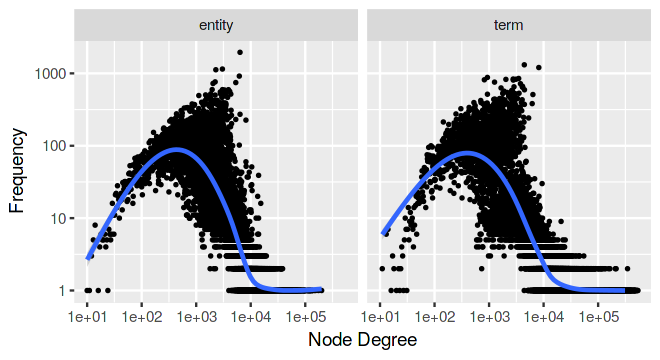

In [19]:
options(repr.plot.width=5.5, repr.plot.height=3)
plot_degree_per_type(node_degree, "Node Degree") + stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))

On the other hand, the hyperedge degree distributions all follow power laws, with the `contained_in` hyperedges having less nodes than `document` or `related_to` hyperedges. This is expected, as `contained_in` hyperedges usually link a few `term` nodes to its corresponding `entity` node.

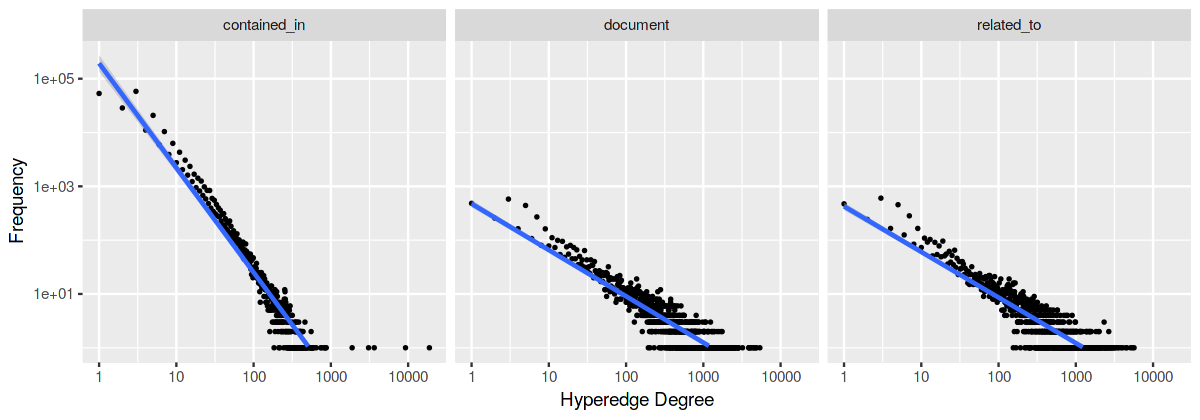

In [20]:
options(repr.plot.width=10, repr.plot.height=3.5)
plot_degree_per_type(edge_degree, "Hyperedge Degree") + stat_smooth(method="lm")

## Global statistics

In [136]:
load_stats_data <- function(base_dir, as_list=FALSE) {
    stats_path <- file.path(base_dir, list.files(path = base_dir, pattern = "stats-.*\\.csv"))

    stats <- read.csv(stats_path, stringsAsFactors = F)
    
    stats
}

In [137]:
stats <- load_stats_data(file.path(base_dir, "global"))
stats

Statistic,Value
Vertices,6.072130e+05
Directed Hyperedges,2.382160e+05
Undirected Hyperedges,1.493800e+04
Total Hyperedges,2.531540e+05
Num Sources,0.000000e+00
Num Sinks,0.000000e+00
Density,3.881173e-06
Avg. Degree,8.338227e-01
Min InEdge Degree,1.000000e+00
Max InEdge Degree,5.384000e+03


## Scalability

In order to better understand the impact of adding more documents and entities to the index, we created several snapshots by limiting the number of documents read from INEX 2009 3T-NL subset test collection. We then obtained the following aggregated statistics from each snapshot studying their evolution for an increasing number of documents:

- Average node degree
 - Average node indegree
 - Average node outdegree
- Average hyperedge degree
 - Average degree for undirected hyperedges
 - Average overall, tail and head degrees for directed hyperedges
- Estimated clustering coefficient
- Estimated average path length and diameter
- General mixed hypergraph density
- Size
 - Number of nodes and hyperedges
 - Number of bytes in disk and memory

We will begin by the node and hyperedge degree. In order to generate the required data, run the scripts in `runs/inex-2009-3t-nl/hgoe/scalability` in order. This will generate indices with a progressively larger number of documents, using the `--limit` argument (snapshots). Inspect will then generate the node and edge degree distributions per index snapshot, properly organizing them in a directory with name `snapshot_<id>_<num_docs>`.

In [138]:
load_snapshots_degree_data <- function(base_dir, type="node") {
    data <- do.call(rbind, lapply(list.files(path = base_dir, include.dirs = TRUE), function(snapshot) {
        snapshot_dir <- file.path(base_dir, snapshot)

        cbind(
            snapshot_name = snapshot,
            snapshot_id = strsplit(snapshot, "_")[[1]][2],
            num_docs = strsplit(snapshot, "_")[[1]][3],
            do.call(paste("load", type, "degree_data", sep="_"), list(base_dir = snapshot_dir)))
    }))
    
    data$num_docs <- as.numeric(as.character(data$num_docs))
    data
}

In [139]:
snapshot_node_degree <- load_snapshots_degree_data(file.path(base_dir, "snapshots"), type="node")
head(snapshot_node_degree)

snapshot_name,snapshot_id,num_docs,node_id,type,degree,indegree,outdegree
snapshot_001_1,001,1,0,entity,123,123,123
snapshot_001_1,001,1,1,entity,123,123,123
snapshot_001_1,001,1,2,entity,123,123,123
snapshot_001_1,001,1,3,entity,123,123,123
snapshot_001_1,001,1,4,entity,123,123,123
snapshot_001_1,001,1,5,entity,123,123,123


In [140]:
snapshot_edge_degree <- load_snapshots_degree_data(file.path(base_dir, "snapshots"), type="edge")
head(snapshot_edge_degree)

snapshot_name,snapshot_id,num_docs,edge_id,type,is_directed,degree,tail_degree,head_degree
snapshot_001_1,001,1,0,document,FALSE,2,NA,NA
snapshot_001_1,001,1,1,related_to,FALSE,1,NA,NA
snapshot_001_1,001,1,2,contained_in,TRUE,3,1,1
snapshot_001_1,001,1,3,contained_in,TRUE,3,1,1
snapshot_001_1,001,1,4,contained_in,TRUE,3,1,1
snapshot_001_1,001,1,5,contained_in,TRUE,3,2,1


In [141]:
plot_degree_over_time <- function(data, label, degree_colname="degree") {
    data <- data %>%
        group_by(num_docs) %>%
        summarize(mean=mean(!!sym(degree_colname), na.rm=TRUE))

    ggplot(data, aes(x=num_docs, y=mean)) +
        geom_line() +
        xlab("Number of Documents") +
        ylab(label)
}
                      
plot_size_over_time <- function(data, label, degree_colname="degree") {
    data <- data %>%
        group_by(num_docs) %>%
        summarize(len=length(!!sym(degree_colname)))

    ggplot(data, aes(x=num_docs, y=len)) +
        geom_line() +
        xlab("Number of Documents") +
        ylab(label)
}

### Average degree

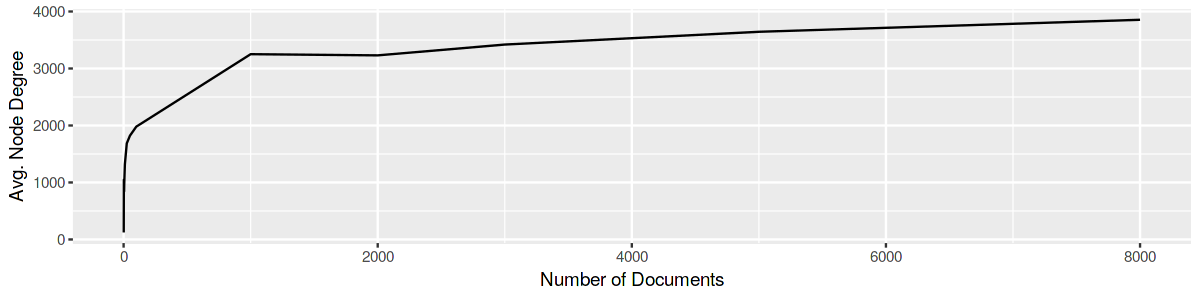

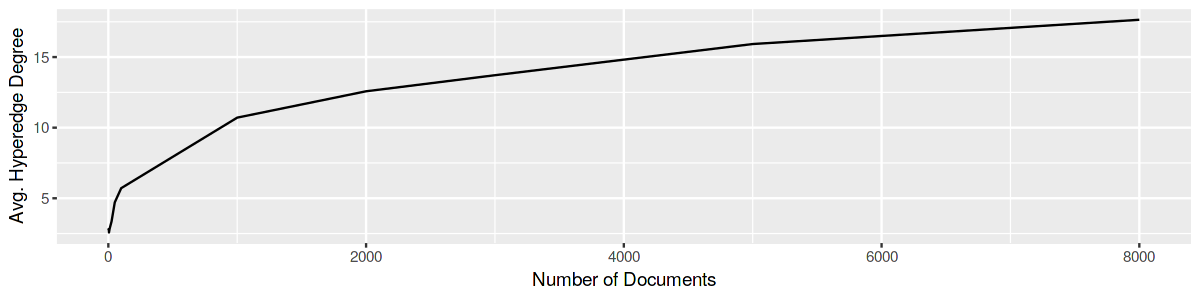

In [142]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_degree_over_time(snapshot_node_degree, "Avg. Node Degree")
plot_degree_over_time(snapshot_edge_degree, "Avg. Hyperedge Degree")

#### Average node indegree

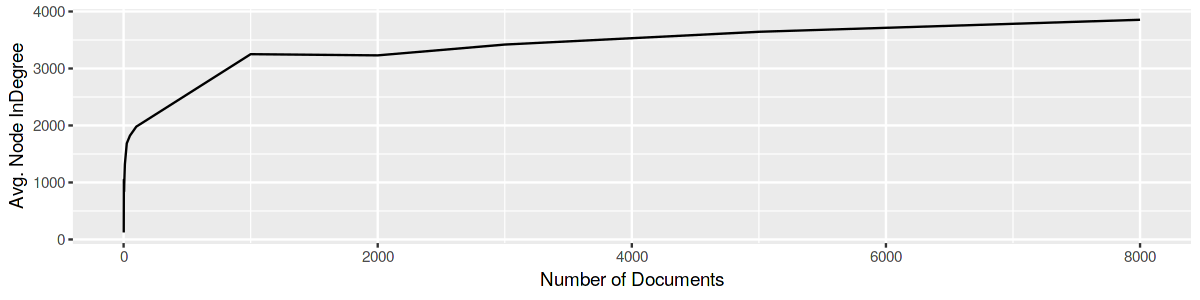

In [143]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_degree_over_time(snapshot_node_degree, "Avg. Node InDegree", degree_colname = "indegree")

#### Average node outdegree

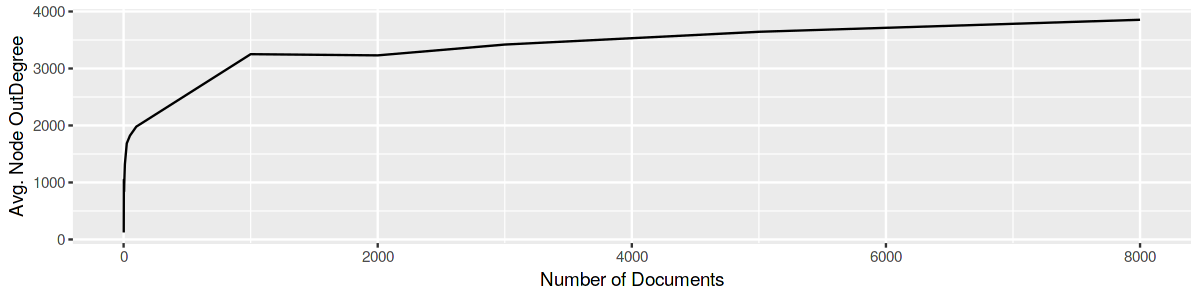

In [144]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_degree_over_time(snapshot_node_degree, "Avg. Node OutDegree", degree_colname = "outdegree")

#### Average degree for undirected hyperedges

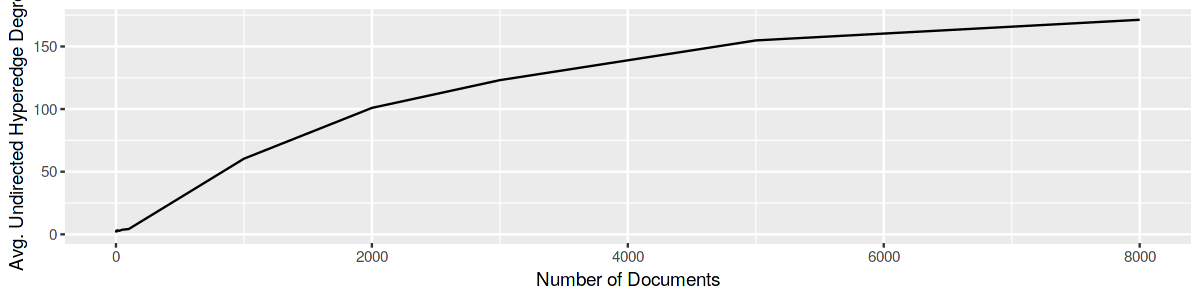

In [145]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_degree_over_time(
    snapshot_edge_degree %>% filter(!is_directed), "Avg. Undirected Hyperedge Degree", degree_colname = "degree")

#### Average overall, tail and head degrees for directed hyperedges

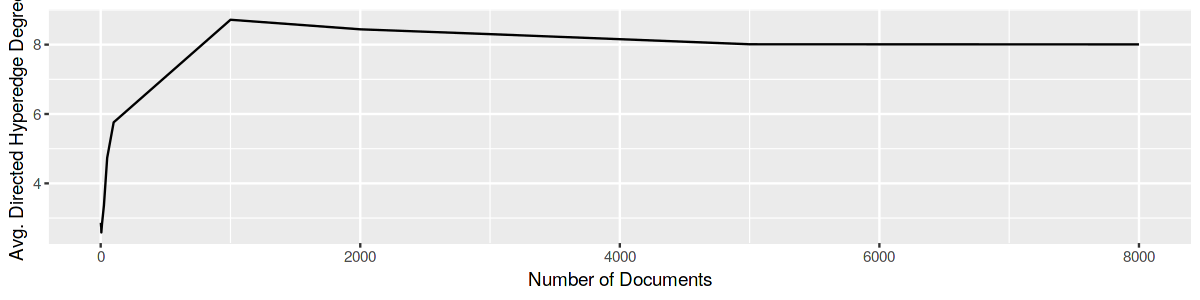

In [146]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_degree_over_time(
    snapshot_edge_degree %>% filter(is_directed), "Avg. Directed Hyperedge Degree", degree_colname = "degree")

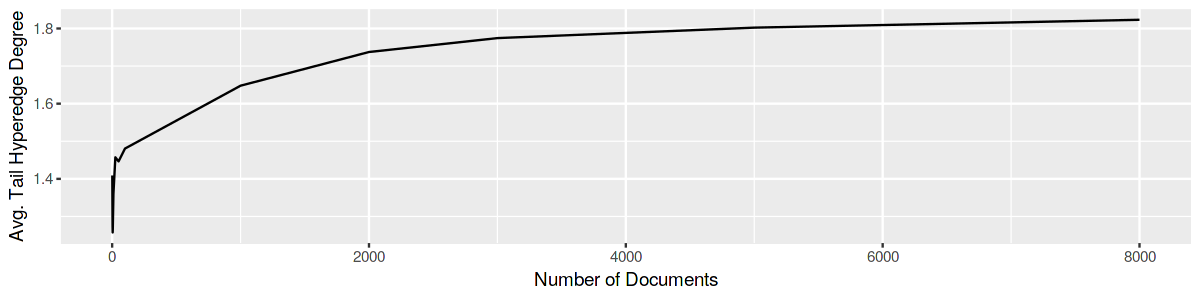

In [147]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_degree_over_time(
    snapshot_edge_degree %>% filter(is_directed), "Avg. Tail Hyperedge Degree", degree_colname = "tail_degree")

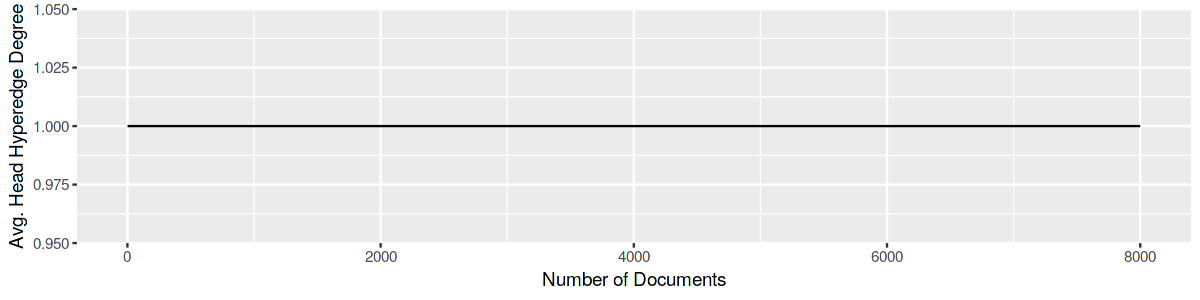

In [148]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_degree_over_time(
    snapshot_edge_degree %>% filter(is_directed), "Avg. Head Hyperedge Degree", degree_colname = "head_degree")

### Estimated clustering coefficient

In [205]:
load_snapshots_stats_data <- function(base_dir) {
    data <- do.call(rbind, lapply(list.files(path = base_dir, include.dirs = TRUE), function(snapshot) {
        snapshot_dir <- file.path(base_dir, snapshot)

        cbind(
            snapshot_name = snapshot,
            snapshot_id = strsplit(snapshot, "_")[[1]][2],
            num_docs = strsplit(snapshot, "_")[[1]][3],
            do.call("load_stats_data", list(base_dir = snapshot_dir)))
    }))
    
    data$num_docs <- as.numeric(as.character(data$num_docs))
    
    setNames(data, c(names(data)[1:3], "statistic", "value"))
}

In [206]:
snapshot_stats <- load_snapshots_stats_data(file.path(base_dir, "snapshots"))
head(snapshot_stats)

snapshot_name,snapshot_id,num_docs,statistic,value
snapshot_001_1,001,1,Vertices,123
snapshot_001_1,001,1,Directed Hyperedges,22
snapshot_001_1,001,1,Undirected Hyperedges,2
snapshot_001_1,001,1,Total Hyperedges,24
snapshot_001_1,001,1,Num Sources,0
snapshot_001_1,001,1,Num Sinks,0


In [233]:
plot_statistics_over_time <- function(data, label, log_scale=FALSE) {
    if (length(unique(data$statistic)) > 1) {
        p <- ggplot(data, aes(x=num_docs, y=value, color=statistic)) +
            scale_color_discrete("Statistic") +
            theme(legend.position="top")
    } else {
        p <- ggplot(data, aes(x=num_docs, y=value))
    }
    
    if (log_scale) {
        p <- p + scale_x_log10() + scale_y_log10()
    }
    
    p + geom_line() +
        xlab("Number of Documents") +
        ylab(label)
}

In [234]:
snapshot_cc <- snapshot_stats[which(snapshot_stats$statistic == "Avg. Clustering Coefficient"), ]
snapshot_cc

,snapshot_name,snapshot_id,num_docs,statistic,value
17,snapshot_001_1,001,1,Avg. Clustering Coefficient,0.5889835
36,snapshot_002_2,002,2,Avg. Clustering Coefficient,0.5544419
55,snapshot_003_3,003,3,Avg. Clustering Coefficient,0.5498533
74,snapshot_004_4,004,4,Avg. Clustering Coefficient,0.5491207
93,snapshot_005_5,005,5,Avg. Clustering Coefficient,0.5061528
112,snapshot_006_10,006,10,Avg. Clustering Coefficient,0.4680211
131,snapshot_007_25,007,25,Avg. Clustering Coefficient,0.3858513
150,snapshot_008_50,008,50,Avg. Clustering Coefficient,0.3224015
169,snapshot_009_100,009,100,Avg. Clustering Coefficient,0.2614454
188,snapshot_010_1000,010,1000,Avg. Clustering Coefficient,0.1610133


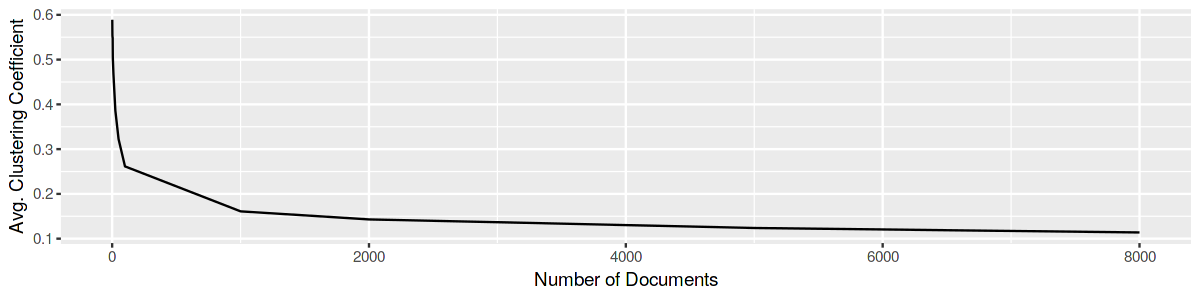

In [238]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_statistics_over_time(snapshot_cc, "Avg. Clustering Coefficient")

### Estimated average path length and diameter

In [236]:
snapshot_paths <- snapshot_stats[which(snapshot_stats$statistic %in% c("Avg. Path Length", "Diameter")), ]
snapshot_paths

,snapshot_name,snapshot_id,num_docs,statistic,value
18,snapshot_001_1,001,1,Diameter,452.000000
19,snapshot_001_1,001,1,Avg. Path Length,124.700000
37,snapshot_002_2,002,2,Diameter,9.000000
38,snapshot_002_2,002,2,Avg. Path Length,4.066667
56,snapshot_003_3,003,3,Diameter,9.000000
57,snapshot_003_3,003,3,Avg. Path Length,3.766667
75,snapshot_004_4,004,4,Diameter,7.000000
76,snapshot_004_4,004,4,Avg. Path Length,3.533333
94,snapshot_005_5,005,5,Diameter,9.000000
95,snapshot_005_5,005,5,Avg. Path Length,4.266667


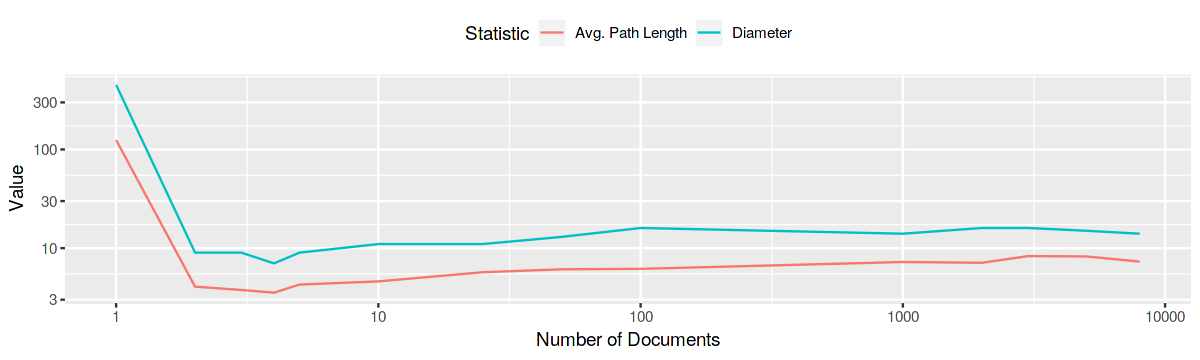

In [240]:
options(repr.plot.width=10, repr.plot.height=3)
plot_statistics_over_time(snapshot_paths, "Value", log_scale = TRUE)

### General mixed hypergraph density

In [241]:
snapshot_density <- snapshot_stats[which(snapshot_stats$statistic == "Density"), ]
snapshot_density

,snapshot_name,snapshot_id,num_docs,statistic,value
7,snapshot_001_1,001,1,Density,1.374522e-03
26,snapshot_002_2,002,2,Density,1.401240e-04
45,snapshot_003_3,003,3,Density,1.047619e-04
64,snapshot_004_4,004,4,Density,9.483004e-05
83,snapshot_005_5,005,5,Density,6.345873e-05
102,snapshot_006_10,006,10,Density,3.428081e-05
121,snapshot_007_25,007,25,Density,1.582643e-05
140,snapshot_008_50,008,50,Density,1.059882e-05
159,snapshot_009_100,009,100,Density,7.659471e-06
178,snapshot_010_1000,010,1000,Density,4.738997e-06


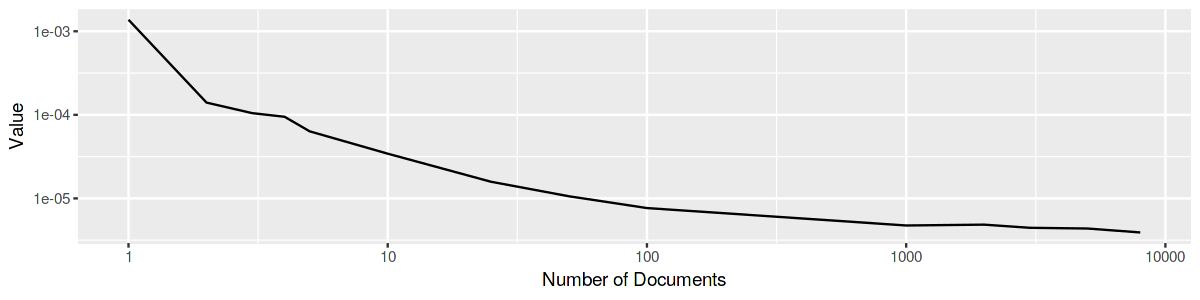

In [243]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_statistics_over_time(snapshot_density, "Value", log_scale = TRUE)

### Size

#### Number of nodes and hyperedges

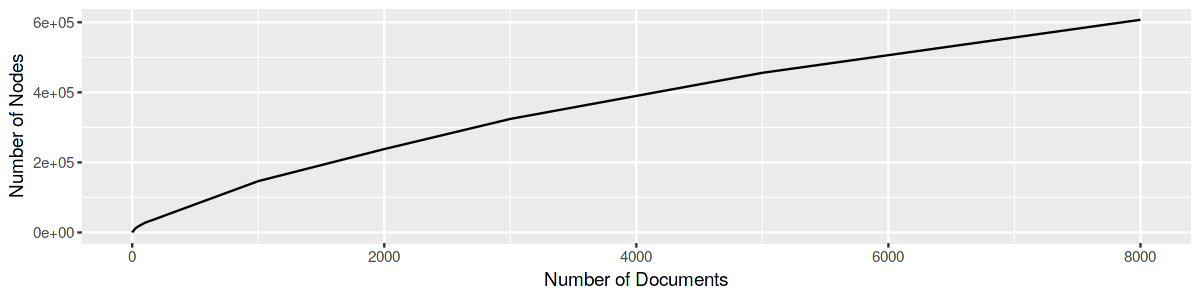

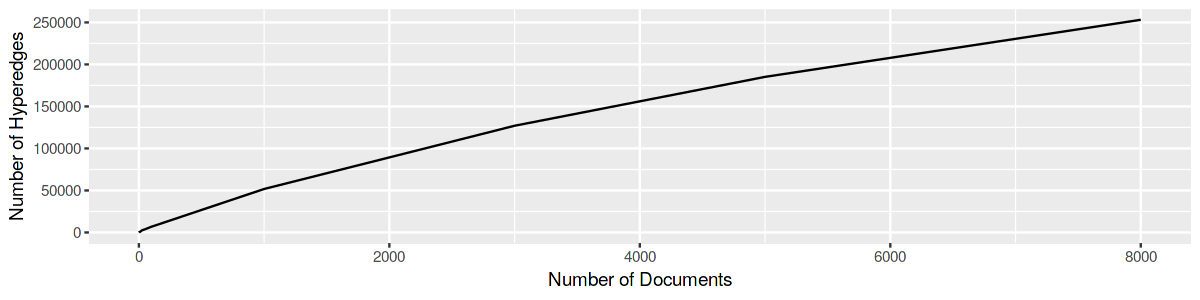

In [75]:
options(repr.plot.width=10, repr.plot.height=2.5)
plot_size_over_time(snapshot_node_degree, "Number of Nodes")
plot_size_over_time(snapshot_edge_degree, "Number of Hyperedges")

#### Number of bytes in disk and memory